In [1]:
def words_in_from_down_to_top_order(sentence_tree):
    #print sentence_tree
    levels = np.setdiff1d(range(len(sentence_tree)),np.unique(sentence_tree)) # - zwraca slowo/a, ktore nie jest niczyim dzieckiem - czyli powinno/y byc korzeniem/korzeniami frazy/fraz
    if len(levels) == 0: # wczesniej bylo != 1, co oznaczalo, ze jezeli okazuje sie jest wiecej niz jeden korzec (lub nie ma korzenia) to zwracamy None, aby pozniej rozpoznac takie zdanie i je wywalic. Ale jak robimy batche to musi byc kilka korzeni
        return None, None
    levels = levels.tolist() 

    for i in range(len(sentence_tree)):
        x = np.setdiff1d(sentence_tree[levels[i]],-1)
        levels.extend(x[x<len(sentence_tree)])
            
    ordered_words = np.array(levels)[levels != np.array(-1)][::-1] #odwracamy kolejnosc na poczatku beda slowa znajdujace sie najglebiej
    
    order = np.zeros(len(sentence_tree),dtype='int')
    for i in range(len(sentence_tree)):
        order[ordered_words[i]] = i

    return ordered_words, order


def load_stanford_data4(labels, parents, tokens, rules, words2ids, use_batch, batch_size, nb_classes):



    sentences = []

    l = open(labels, "r")
    # 5 klas: labels = [[2 if y=='#' else int(y)+2 for y in x.split()] for x in l.readlines()] 

    # Na ten moment przyjmujemy wartosc "2" w miejsce "#"

    labels = [[int(y) for y in x.split()] for x in l.readlines()] 
    l.close()

    p = open(parents,"r")
    parents = [[int(y) for y in x.split()] for x in p.readlines()]
    p.close()

    t = open(tokens,"r")
    tokens = [x.split() for x in t.readlines()]
    t.close()
    
    r = open(rules,"r")
    rules = [x.split() for x in r.readlines()]
    r.close()
    
    k = 0
    sentence_length = 0
    current_batch, batch_tokens, batch_children_ids, batch_children_positions, batch_labels = [], [], [], [], []
    batch_words = []
    
    for labels_i, parents_i, tokens_i, rules_i in zip(labels,parents,tokens,rules):
        
        k = k + 1
         
        s = []
        for i in range(len(tokens_i)):
            
            if tokens_i[i] == "__nonterminal__":
                token = "__nonterminal__"+rules_i[i]
            else:
                token = tokens_i[i]
            
            
            s.append([i,int(parents_i[i]),labels_i[i],token])

        if len(s) == 1 and use_batch == False: #przypadek gdy fraza sklada sie z jednego tokena

            #if nb_classes == 2:
            #    if s[0][-1] < 0:
            #        continue

            sentences.append([\
                                  np.array([words2ids.get(tokens[0], -1)]),\
                                  #wyrzucamy macierz id dzieci numpy.array([-1], ndmin=2),\
                                  np.array([-1], ndmin=2), \
                                  np.array(labels_i[0]) \
                                  #,numpy.array([0])
                              ])    
                                
        else: 

            for i in range(len(s)): # nie wiem czy sie nie wywali dla frazy dlugosci 1
                children = []
                for j in range(len(s)):
                    if s[j][1] == i+1:
                        children.append(s[j][0])
                s[i].append(children)

            words = [x[0] for x in s]
            children = seq.pad_sequences([x[4] for x in s], padding='post', value = -1)
            tokens = [x[3] for x in s]
            labels_in_batch = [x[2] for x in s]
            
            ordered_words, order = words_in_from_down_to_top_order(children)

            if ordered_words is None: 
                continue

            current_sentence = [
                                  np.array([words2ids.get(x,-1) for x in tokens])[ordered_words],
                                  #wyrzucamy macierz id dzieci numpy.array([[words2ids.get(tokens[w],-1) if w>=0 else -1 for w in x] 
                                  #             for x in children[ordered_words]]), 
                                  np.array([[order[w] if w>= 0 else -1 for w in x] for x in children[ordered_words]]), 
                                  np.array(labels_in_batch)[ordered_words] 
                                  ,np.array(words)
                                  ]
            #if nb_classes == 2:
            #    if current_sentence[3][-1] <0:
            #        continue

            if use_batch == True:
                
                # w tej chwili len(current_sentence[0]) nie jest nigdzie wykorzystywane
                current_batch.append((current_sentence, len(current_sentence[0])))
                
                if len(current_batch) % batch_size == 0:

                    shift = 0
                    
                    for sent in range(batch_size):
                        
                        ##if sent > 0:
                        ##    shift = shift + current_batch[sent-1][1]
                        
                        for tok in range(len(current_batch[sent][0][0])):
                            
                            if sent == 0:
                                batch_children_positions.append(current_batch[sent][0][1][tok])
                            else:
                                batch_children_positions.append([chd+shift if chd>=0 else -1 for chd in current_batch[sent][0][1][tok]])
                            #batch_children_positions.append(current_batch[sent][0][2][tok])

                            batch_tokens.append(current_batch[sent][0][0][tok])   
                            #wyrzucamy macierz id dzieci batch_children_ids.append(current_batch[sent][0][1][tok])
                            batch_labels.append(current_batch[sent][0][2][tok])
                            batch_words.append(current_batch[sent][0][3][tok])
                                                               
                    #wyrzucamy macierz id dzieci batch_children_ids = seq.pad_sequences(batch_children_ids, padding='post', value = -1)
                    batch_children_positions = seq.pad_sequences(batch_children_positions, padding='post', value = -1)
                    
                    sentences.append([
                                        np.array(batch_tokens), 
                                        #wyrzucamy macierz id dzieci numpy.array(batch_children_ids), 
                                        np.array(batch_children_positions), 
                                        np.array(batch_labels)
                                        ,np.array(batch_words)
                                    ])
                    
                    current_batch, batch_tokens, batch_children_positions, batch_labels = [], [], [], []
                    batch_words = []
                                       
            else:
                
                sentences.append(current_sentence)

            
    # gdy liczba zdan nie jest wilokrotnosci licznosci batch, to na koncu trzeba dodac pozostale zdania:
    if use_batch == True and len(current_batch) > 0:
        
        shift = 0

        for sent in range(len(current_batch)):
 
            #if sent > 0:
            #    shift = shift + current_batch[sent-1][1]

            for tok in range(len(current_batch[sent][0][0])):

                if sent == 0:
                    batch_children_positions.append(current_batch[sent][0][1][tok])
                else:
                    batch_children_positions.append([chd+shift if chd>=0 else -1 for chd in current_batch[sent][0][1][tok]])
                #batch_children_positions.append(current_batch[sent][0][2][tok])

                batch_tokens.append(current_batch[sent][0][0][tok])
                #wyrzucamy macierz id dzieci batch_children_ids.append(current_batch[sent][0][1][tok])
                batch_labels.append(current_batch[sent][0][2][tok])
                batch_words.append(current_batch[sent][0][3][tok])


        #wyrzucamy macierz id dzieci batch_children_ids = seq.pad_sequences(batch_children_ids, padding='post', value = -1)
        batch_children_positions = seq.pad_sequences(batch_children_positions, padding='post', value = -1)

        sentences.append([
                            np.array(batch_tokens), 
                            #wyrzucamy macierz id dzieci numpy.array(batch_children_ids), 
                            np.array(batch_children_positions), 
                            np.array(batch_labels)
                            ,np.array(batch_words)
                        ])
           
    return sentences

In [2]:
from tools import *
import glob
import os
import pickle
import matplotlib.pyplot as plt

%matplotlib inline


import numpy as np
import random
import time
import os
import itertools
import pickle
import  csv
from collections import Counter, OrderedDict

from keras.preprocessing import sequence as seq

import theano
from theano import tensor as T
from theano.ifelse import ifelse
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams 

class TreeLSTM(object):  

    def __init__(self, h_dim, nc, w2v_model_path, file_with_rules, 
                 rules_emb_dim, max_phrase_length, emb_dropout_rate, h_dropout_rate, l, srng,
                load_params=None): 

        '''

        - dropout stanu ukrytego (LSTM_1)
        - dropout embeddinga (LSTM_1)
        - regularyzacja l2 (LSTM_1)
        - indywidualna obsluga lisci - struktura taka sama, macierze te same, ale uczymy: h_aggregated_0, hidden_state_0, cell_state_0, zamiast brac w te miejsca 0


        nh :: dimension of hidden state
        nc :: number of classes
        '''

        self.max_phrase_length = max_phrase_length

        w2vecs = pickle.load(open(w2v_model_path,"rb"))
        self.emb = theano.shared(w2vecs["vectors"].astype(theano.config.floatX))
        self.words2ids = w2vecs["words2ids"]

        emb_dim = w2vecs["vectors"].shape[1]
        del w2vecs

        
        r = open(file_with_rules,"r")
        rules = [x.split() for x in r.readlines()]
        r.close()
        unique_rules = set()
        for i in range(len(rules)):
            for j in range(len(rules[i])):
                unique_rules.add(rules[i][j])
                
        number_of_uniue_rules = len(unique_rules)
 
        r = 0.05

        self.rules2ids = dict(zip(unique_rules,range(number_of_uniue_rules)))
        self.emb_rules = theano.shared(r * np.random.uniform(-1,1,(number_of_uniue_rules, rules_emb_dim)).astype(theano.config.floatX))
        
   

        self.W_i = theano.shared(r * np.random.uniform(-1.0, 1.0, (emb_dim+rules_emb_dim, h_dim) ).astype(theano.config.floatX))
        self.U_i = theano.shared(r * np.random.uniform(-1.0, 1.0, (h_dim, h_dim) ).astype(theano.config.floatX))
        self.b_i = theano.shared(r * np.random.uniform(-1.0, 1.0, h_dim ).astype(theano.config.floatX))

        self.W_f = theano.shared(r * np.random.uniform(-1.0, 1.0, (emb_dim+rules_emb_dim, h_dim) ).astype(theano.config.floatX))
        self.U_f = theano.shared(r * np.random.uniform(-1.0, 1.0, (h_dim, h_dim) ).astype(theano.config.floatX))
        self.b_f = theano.shared(r * np.random.uniform(-1.0, 1.0, h_dim ).astype(theano.config.floatX))

        self.W_o = theano.shared(r * np.random.uniform(-1.0, 1.0, (emb_dim+rules_emb_dim, h_dim) ).astype(theano.config.floatX))
        self.U_o = theano.shared(r * np.random.uniform(-1.0, 1.0, (h_dim, h_dim) ).astype(theano.config.floatX))
        self.b_o = theano.shared(r * np.random.uniform(-1.0, 1.0, h_dim ).astype(theano.config.floatX))

        self.W_u = theano.shared(r * np.random.uniform(-1.0, 1.0, (emb_dim+rules_emb_dim, h_dim) ).astype(theano.config.floatX))
        self.U_u = theano.shared(r * np.random.uniform(-1.0, 1.0, (h_dim, h_dim) ).astype(theano.config.floatX))
        self.b_u = theano.shared(r * np.random.uniform(-1.0, 1.0, h_dim ).astype(theano.config.floatX))

        self.W_y   = theano.shared(r * np.random.uniform(-1.0, 1.0, (h_dim, nc)).astype(theano.config.floatX))
        self.b_y   = theano.shared(r * np.random.uniform(-1.0, 1.0, nc).astype(theano.config.floatX))




        self.h_aggregated_0 = theano.shared(r * np.random.uniform(-1.0, 1.0, h_dim ).astype(theano.config.floatX))
        self.cell_state_0 = theano.shared(r * np.random.uniform(-1.0, 1.0, h_dim ).astype(theano.config.floatX))
        self.hidden_state_0 = theano.shared(r * np.random.uniform(-1.0, 1.0, h_dim ).astype(theano.config.floatX))



        self.srng = srng
        self.h_dropout_rate = h_dropout_rate
        self.emb_dropout_rate = emb_dropout_rate
        self.l = l


        if load_params:
            for key in load_params.keys():
                if key not in ['emb', 'emb_rules', 'W_i', 'U_i', 'b_i', 'W_f', 'U_f', 'b_f', 'W_o', 'U_o', 'b_o', 'W_u', 'U_u', 'b_u', 'W_y', 'b_y', 'h_aggregated_0', 'cell_state_0', 'hidden_state_0']:
                    setattr(self, key, load_params[key])
                else:
                    setattr(self, key, theano.shared(load_params[key]))
        
        

        def one_step(word_id, rule_id, word_children_positions, y_true, k, hidden_states, cell_states, learning_rate):

            x = T.concatenate( [self.emb[word_id], self.emb_rules[rule_id] ])

            #dropout:
            mask1 = self.srng.binomial(n=1, p=1-self.emb_dropout_rate, size=(emb_dim+rules_emb_dim,), dtype='floatX')
            x = x * mask1


            tmp = word_children_positions>=0.0
            number_of_children = tmp.sum(dtype = theano.config.floatX) 
            idx_tmp = tmp.nonzero()                                                                   # indeksy realne dzieci - czyli te, gdzie nie ma -1        

            h_aggregated = ifelse(T.gt(number_of_children, 0.0), hidden_states[word_children_positions[idx_tmp]].sum(axis=0), self.h_aggregated_0)


            i = T.nnet.sigmoid(	T.dot(x, self.W_i) + T.dot(h_aggregated, self.U_i) + self.b_i)             

            o = T.nnet.sigmoid(	T.dot(x, self.W_o) + T.dot(h_aggregated, self.U_o) + self.b_o)             

            u = T.tanh(	T.dot(x, self.W_u) + T.dot(h_aggregated, self.U_u) + self.b_u)             

            f_c = ifelse(T.gt(number_of_children, 0.0), 
                (T.nnet.sigmoid( T.dot(x, self.W_f ) + T.dot(hidden_states[word_children_positions[idx_tmp]], self.U_f)  + self.b_f )*cell_states[word_children_positions[idx_tmp]]).sum(axis=0),
                T.nnet.sigmoid( T.dot(x, self.W_f ) + T.dot(self.hidden_state_0, self.U_f)  + self.b_f ) * self.cell_state_0
            )

            c = i*u + f_c

            h = o * T.tanh(c)
            #dropout:
            mask = self.srng.binomial(n=1, p=1-self.h_dropout_rate, size=(h_dim,), dtype='floatX')
            h = h * mask


            current_cell_state = cell_states[k]
            cell_states_new = T.set_subtensor(current_cell_state, c)

            current_hidden_state = hidden_states[k]
            hidden_states_new = T.set_subtensor(current_hidden_state, h)


            y_prob = T.nnet.softmax(T.dot(h,self.W_y) + self.b_y)[0]

            cross_entropy = -T.log(y_prob[y_true])						       # + norm_coefficient * l2_norm

            return cross_entropy, hidden_states_new, cell_states_new  


        y = T.vector('y',dtype=dataType)
        learning_rate = T.scalar('lr',dtype=theano.config.floatX)
        words = T.vector(dtype=dataType)
        rules = T.vector(dtype=dataType)
        children_positions = T.matrix(dtype=dataType)
        words_indexes = T.vector(dtype=dataType)

        [cross_entropy_vector, _, _] , _ = theano.scan(fn=one_step, \
                                 sequences = [words, rules, children_positions,y,words_indexes],
                                 outputs_info = [None, 
                                     theano.shared(np.zeros((self.max_phrase_length+1,h_dim), dtype = theano.config.floatX)),
                                     theano.shared(np.zeros((self.max_phrase_length+1,h_dim), dtype = theano.config.floatX))],
                                 non_sequences = learning_rate,
                                 n_steps = words.shape[0])

        cost = T.mean(cross_entropy_vector) + self.l * (self.emb_rules**2).sum() #*0.5 * self.l * ((self.W_i**2).sum()+(self.W_f**2).sum()+(self.W_o**2).sum()+(self.W_u**2).sum()+(self.W_y**2).sum()+(self.U_i**2).sum()+(self.U_f**2).sum()+(self.U_o**2).sum()+(self.U_u**2).sum())

        updates = OrderedDict([
            (self.W_i, self.W_i-learning_rate*T.grad(cost, self.W_i)),
            (self.W_f, self.W_f-learning_rate*T.grad(cost, self.W_f)),
            (self.W_o, self.W_o-learning_rate*T.grad(cost, self.W_o)),
            (self.W_u, self.W_u-learning_rate*T.grad(cost, self.W_u)),
            (self.W_y, self.W_y-learning_rate*T.grad(cost, self.W_y)),

            (self.U_i, self.U_i-learning_rate*T.grad(cost, self.U_i)),
            (self.U_f, self.U_f-learning_rate*T.grad(cost, self.U_f)),
            (self.U_o, self.U_o-learning_rate*T.grad(cost, self.U_o)),
            (self.U_u, self.U_u-learning_rate*T.grad(cost, self.U_u)),

            #(self.emb, self.emb-learning_rate*T.grad(cost, self.emb)), #SPROBOWAC TU 0.1 ZAMIAST LR, A DLA POLSKICH BEZ AKTUALIZACJI EMB
            (self.emb_rules, self.emb_rules-learning_rate*T.grad(cost, self.emb_rules)),
            (self.b_i, self.b_i-learning_rate*T.grad(cost,self.b_i)),
                        (self.b_f, self.b_f-learning_rate*T.grad(cost,self.b_f)),
                        (self.b_o, self.b_o-learning_rate*T.grad(cost,self.b_o)),
                        (self.b_u, self.b_u-learning_rate*T.grad(cost,self.b_u)),
                        (self.b_y, self.b_y-learning_rate*T.grad(cost,self.b_y)),

            (self.h_aggregated_0, self.h_aggregated_0-learning_rate*T.grad(cost,self.h_aggregated_0)),
            (self.cell_state_0, self.cell_state_0-learning_rate*T.grad(cost,self.cell_state_0)),
            (self.hidden_state_0, self.hidden_state_0-learning_rate*T.grad(cost,self.hidden_state_0))

            ])

        self.train = theano.function( inputs  = [words, rules, children_positions, y, words_indexes, learning_rate],
                                      outputs = [],
                                      updates = updates,
                                      allow_input_downcast=True,
                                      mode='FAST_RUN'
                                      )


        def one_step_classify(word_id, rule_id, word_children_positions, k, hidden_states, cell_states):

            x = T.concatenate( [self.emb[word_id], self.emb_rules[rule_id] ])

            x = (1-self.emb_dropout_rate) * x

            tmp = word_children_positions>=0.0
            number_of_children = tmp.sum(dtype = theano.config.floatX) 
            idx_tmp = tmp.nonzero()                                                                   # indeksy realne dzieci - czyli te, gdzie nie ma -1        

            h_aggregated = ifelse(T.gt(number_of_children, 0.0), hidden_states[word_children_positions[idx_tmp]].sum(axis=0), self.h_aggregated_0)

            i = T.nnet.sigmoid(	T.dot(x, self.W_i) + T.dot(h_aggregated, self.U_i) + self.b_i)             

            o = T.nnet.sigmoid(	T.dot(x, self.W_o) + T.dot(h_aggregated, self.U_o) + self.b_o)             

            u = T.tanh(	T.dot(x, self.W_u) + T.dot(h_aggregated, self.U_u) + self.b_u)             

            f_c = ifelse(T.gt(number_of_children, 0.0), 
                (T.nnet.sigmoid( T.dot(x, self.W_f ) + T.dot(hidden_states[word_children_positions[idx_tmp]], self.U_f)  + self.b_f )*cell_states[word_children_positions[idx_tmp]]).sum(axis=0),
                T.nnet.sigmoid( T.dot(x, self.W_f ) + T.dot(self.hidden_state_0, self.U_f)  + self.b_f ) * self.cell_state_0
            )

            c = i*u + f_c

            h = o * T.tanh(c)
            # podczas uczenia zerowalismy 1-dropout_rate procent wspolrzednych, wiec trzeba to 
            h = h * (1-self.h_dropout_rate)

            current_cell_state = cell_states[k]
            cell_states_new = T.set_subtensor(current_cell_state, c)

            current_hidden_state = hidden_states[k]
            hidden_states_new = T.set_subtensor(current_hidden_state, h)


            y_prob = T.nnet.softmax(T.dot(h,self.W_y) + self.b_y)[0]             

            return  y_prob, hidden_states_new, cell_states_new


        [y_probs_classify, _ , _ ], _ = theano.scan(
                 fn=one_step_classify, 
                                 sequences = [words, rules, children_positions, words_indexes],
                 outputs_info = [None,
                         theano.shared(np.zeros((self.max_phrase_length+1,h_dim), dtype = theano.config.floatX)),
                         theano.shared(np.zeros((self.max_phrase_length+1,h_dim), dtype = theano.config.floatX))])

        predictions, _ = theano.scan(lambda i: T.argmax(y_probs_classify[i]), 
                                     sequences = [words_indexes])
        
        probs, _ = theano.scan(lambda i: y_probs_classify[i], 
                                     sequences = [words_indexes])

        self.classify = theano.function(inputs=[words, rules, children_positions,words_indexes], 
                                     outputs=predictions,
                                     allow_input_downcast=True,
                                     mode='FAST_RUN' 
                                     )

        self.predict_proba = theano.function(inputs=[words, rules, children_positions,words_indexes], 
                             outputs=probs,
                             allow_input_downcast=True,
                             mode='FAST_RUN' 
                             )



        
        
s = {'lr':0.05,
         'nepochs':80,
         'seed':345,
         'nc':2,        # number of y classes
         'h_dim': 100,
         'h_dropout_rate': 0.5,
         'emb_dropout_rate': 0.5,
         'time_without_improvement': 10,
         'batch_size': 1,
         'w2v_DIM': "300",
         "rules_emb_dim": 30
         }  

dataType = 'int64'
  
np.random.seed(s['seed']) 

params = dict(pickle.load(open("model_params.pkl","rb")))

rnn = TreeLSTM( h_dim = s['h_dim'],
            nc = s['nc'],
        w2v_model_path = "embeddings/filtered_w2v_allwiki_nkjpfull_300.pkl",
            max_phrase_length = 60,
        emb_dropout_rate = s['emb_dropout_rate'],
        h_dropout_rate = s['h_dropout_rate'],
        l = 0.0001,
        srng = RandomStreams(12345),
        file_with_rules =  "Data/rules.txt",
        rules_emb_dim = s["rules_emb_dim"],
        load_params= params
    )        

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using Theano backend.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:156: UserWarning: DEPRECATION: If x is a vector, Softmax will not automatically pad x anymore in next releases. If you need it, please do it manually. The vector case is gonna be supported soon and the output will be a vector.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:249: UserWarning: DEPRECATION: If x is a vector, Softmax will not automatically pad x anymore in next releases. If you need it, please do it manually. The vector case is gonna be supported soon and the output will be a vector.


In [3]:
w2vecs_full = pickle.load(open("embeddings/w2v_allwiki_nkjpfull_300.pkl","rb"),encoding="latin1")

datasets = ["Data/tokens.txt"]

words = set()
for dataset in datasets:
    with open(dataset) as f:
        for x in f.read().split():
            words.add(x)
            
words2ids_filtered = {}
vectors_filtered = []

i = 0
for word in w2vecs_full.index2word:
    if word in words:
        words2ids_filtered[word] = i
        vectors_filtered.append(w2vecs_full[word])
        i = i + 1
        
        
t = open("Data/tokens.txt","r")
tokens = [x.split() for x in t.readlines()]
t.close()
r = open("Data/rules.txt","r")
rules = [x.split() for x in r.readlines()]
r.close()


tokens2 = [[]]*len(tokens)
unique_rules = set()
for i in range(len(tokens)):
    for j in range(len(tokens[i])):
        if tokens[i][j][:2] == "__":
            tokens2[i].append(tokens[i][j]+rules[i][j])
            unique_rules.add(tokens[i][j]+rules[i][j])
        else:
            tokens2[i].append(tokens[i][j])
            
            
for i, x in zip(range(len(vectors_filtered), len(vectors_filtered) + len(unique_rules)), unique_rules):
    
    words2ids_filtered[x] = i
    vectors_filtered.append(np.random.uniform(-0.1,0.1,300))
    
vectors_filtered.append(np.random.uniform(-0.1,0.1,300))
vectors_filtered = np.array(vectors_filtered)


w2vecs = {}
w2vecs["words2ids"] = words2ids_filtered
w2vecs["vectors"] = vectors_filtered

pickle.dump(w2vecs,open("embeddings/filtered_w2v_allwiki_nkjpfull_300.pkl","wb"))

In [4]:
def _check_sentence(xml_tree, accept_tags=["forest","tree"]):
    
    """
    Funkcja sprawdza poprawnosc wypowiedzenia i arumentu: 
    - czy istnieje dla niego poprawne drzewo - wypowiedzenie jest poprawne jesli base_answer na polu "type" ma wartosc "FULL".
    - arumentem powinno byc drzewo o tagu korzenia rownym "forest" lub "tree".
    [W oryginalnych plikach z lasami jest to "forest", natomiast gdy z lasu tworzone sa pojedyncze drzewa,
    to maja one tag "tree"]
    
    xml_tree - las drzew lub drzewo [xml.etree.ElementTree.ElementTree]
    """
    
    if type(xml_tree) != ET.ElementTree:
        raise AssertionError("Bad argument type")
    
    
    if type(accept_tags) == str:
        accept_tags = [accept_tags]
    
    
    if not xml_tree.getroot().tag in accept_tags:
        raise AssertionError('Argument in not in [' + ",".join(accept_tags) + '] - it has tag "' + xml_tree.getroot().tag + '"' )
    
    
    base_answer_type = xml_tree.getroot().find('.//answer-data//base-answer').attrib["type"]
    correct = base_answer_type == "FULL"

    if not correct:
        raise AssertionError("Sentence is not correct: Node <base-answer> has type value " + base_answer_type  + " instead of 'FULL'")
        
    pass

In [5]:
def set_random_initial_best_choices(forest):

    forest = deepcopy(forest)

    # sprawdzenie poprawnosci lasu i ewentualne wypisanie komunikatu
    #_check_sentence(forest,"forest")

    nids = [int(x.attrib["nid"]) for x in forest.getroot().findall("node")]

    for nid in nids:
        children = forest.getroot().find(".//node[@nid='"+str(nid)+"']").findall("children")
        if len(children) == 1:
            children[0].set("current_best_choice","true")
        elif len(children) > 1:
            random_choice = np.random.choice(len(children))
            for c in range(len(children)):
                if c == random_choice:
                    children[c].set("current_best_choice","true")
                else:
                    children[c].set("current_best_choice","false")

    return forest


In [6]:
def get_current_best_tree(forest):
    
    """
 
    
    forest - las drzew [xml.etree.ElementTree.ElementTree]
    """

    # sprawdzenie poprawnosci lasu i ewentualne wypisanie komunikatu
    _check_sentence(forest,"forest")
            
    root_old = forest.getroot()
    root_new = ET.Element("tree",root_old.attrib)
    
    
    # las sklada sie z drzew (wezly "node") oraz dodatkowych danych (inne wezly) -
    # tresc wypowiedzenia, statystyki lasu, itd. - i tutaj przepisujemy te wezly
    features = root_old.getchildren()
    for feature in features:
        if feature.tag != "node": 
            feature_copy = deepcopy(feature)
            if feature_copy.tag == "stats":
                feature_copy.tag = "forest-stats"
                
            root_new.append(feature_copy) # modyfikujemy tag wezla wiec potrzebna kopia, zeby nie zmodyfikowac oryginalnego drzewa
            
    # definiujemy rekurencyjna funkcje, ktora bedzie przechodzic po lesie i
    # kolekcjonowac wezly, tworzac losowe drzewo.
    # drzewo jest tworzone na korzeniu root_new.
    def add_current_best_children(current_node_old):
        
        current_node_new = ET.SubElement(root_new, current_node_old.tag, current_node_old.attrib)
        
        features = current_node_old.getchildren()
        # kazdy "node" jest terminalem albo nieterminalem i ma opis wlasnosci
        # i tutaj wyciagamy te wlasnosci z wezla innego niz "children"
        for feature in features:
            if feature.tag != "children": 
                current_node_new.append(feature)
        
        
        children_old = current_node_old.findall('children[@current_best_choice="true"]')
        # powinno byc tylko jedno takie dziecko
        
        assert len(children_old) <= 1, 'More than one children has current_best_choice="true"'
        
        if len(children_old) == 0: #jestesmy w lisciu wiec konczymy dzialanie funkcji
            return None
        
        #random_children_old = children_old[np.random.choice(len(children_old),1)[0]]
        children_new = ET.SubElement(current_node_new, children_old[0].tag, children_old[0].attrib)
        for child_old in children_old[0].getchildren():
            x = ET.SubElement(children_new, child_old.tag, child_old.attrib)
            next_node = root_old.find('.//node[@nid="' + x.attrib["nid"] + '"]')
            # jesli wpiszemy node'om znacznik to to wlaczyc: assert next_node.attrib["current_best_choice"] == "true"
            add_current_best_children(next_node)
        
    
    # wezel startowy (przyjmujemy, ze node z id=0 jest zawsze pierwszy):
    # TODO: upewnic sie czy to jest poprawne podejscie - czy moze byc inny wezel poczatkowym
    node_0 = root_old.find('.//node[@nid="0"][@chosen="true"]')  # current_best_choice
    
    # konstruujemy drzewo:
    add_current_best_children(node_0)
    
    current_best_tree = ET.ElementTree(root_new)

    ## Sprawdzenie poprawnosci drzewa
    #assert is_positive(positive_tree), """Something gone wrong - tree is not positive"""
        
        
    return current_best_tree
        
  

In [7]:
def get_random_disjunctive_node(forest):
    
    _check_sentence(forest)
    
    nids = [int(x.attrib["nid"]) for x in forest.getroot().findall("node")]
    
    nodes_with_many_options = []
    
    for nid in nids:
        children = forest.getroot().find(".//node[@nid='"+str(nid)+"']").findall("children")
        if len(children) > 1:
            nodes_with_many_options.append(nid)
            
    return np.random.choice(nodes_with_many_options)

In [8]:
def get_trees_with_different_choice(forest, nid):
    
    forest = deepcopy(forest)
    
    trees = []
    
    children = forest.getroot().find(".//node[@nid='"+str(nid)+"']").findall("children")
    for i in range(len(children)):
        children[i].set("current_best_choice","false") 
    children[0].set("current_best_choice","true")  
    
    trees.append(get_current_best_tree(forest))
    
    
    for i in range(1,len(children)):
        children[i-1].set("current_best_choice","false") 
        children[i].set("current_best_choice","true")  
        trees.append(get_current_best_tree(forest))

    return trees

In [9]:
def write_dependency_format(dep_tree, folder, overwrite=False):
    
    if not overwrite:
        mode = "a+"
    else:
        mode = "w"
    
    tokens = [x[0] for x in dep_tree]
    with open(folder+"/tokens.txt", mode) as f:
        f.write(" ".join(tokens) + "\n")
        
    rules = [x[1] for x in dep_tree]
    with open(folder+"/rules.txt", mode) as f:
        f.write(" ".join(rules) + "\n")
        
    parents = [str(x[2]) for x in dep_tree]
    with open(folder+"/parents.txt", mode) as f:
        f.write(" ".join(parents) + "\n")
        
    labels = [str(x[3]) for x in dep_tree]
    with open(folder+"/labels.txt", mode) as f:
        f.write(" ".join(labels) + "\n")


In [10]:
def get_best_option(trees, model):
    
    probs = []
    for tree in trees:

        directory = "Data/tmp"
        write_dependency_format(transform_to_dependency_format(tree), directory, overwrite=True)

        positive_tree = get_positive_tree(forest)

        data0 = load_stanford_data4(directory+"/labels.txt", directory+"/parents.txt",directory+"/tokens.txt",directory+"/rules.txt",w2vecs["words2ids"],True,s['batch_size'],s['nc'])

        data_rules = load_stanford_data4(directory+"/labels.txt", directory+"/parents.txt",directory+"/rules.txt",directory+"/rules.txt",rnn.rules2ids,True,s['batch_size'],s['nc'])
        data_rules = [x[0] for x in data_rules]

        data = [data0[i]+[data_rules[i]] for i in range(len(data0))]


        probs.append(model.predict_proba(data[0][0],data[0][4],data[0][1], data[0][3])[-1,1])

        best_choice = np.argmax(probs)
        
    return best_choice, probs[best_choice]

In [11]:
def update_current_best_choices(forest, nid, best_choice):
    
    
    #forest = deepcopy(forest)
    
    children = forest.getroot().find(".//node[@nid='"+str(nid)+"']").findall("children")
    
    for i in range(len(children)):
        if i == best_choice:
            children[i].set("current_best_choice","true")
        else:
            children[i].set("current_best_choice","false") 
    
    
    #return forest

In [12]:
def scores(positive_tree, selected_tree):
    """
    Ta funkcja powinna byc w osobnym module pt "narzedzia do ewaluacji modeli.
    
    wszystkie inne do przetwarzania drzew powinny byc w module pt "ptrzetwarzanie danych"
    """
    gold_nodes = set([node.attrib["nid"] for node in positive_tree.findall('node[@chosen="true"]')])
    selected_nodes = set([node.attrib["nid"] for node in selected_tree.findall('node')])
    intersection = set.intersection(gold_nodes, selected_nodes)
    
    precision = len(intersection)/len(selected_nodes)
    recall = len(intersection)/len(gold_nodes)
    f1 = 2/(1/precision+1/recall)
    return precision, recall, f1

In [ ]:
def disambiguate(forest, model, early_stopping=50):
    
    history = [], []
    positive_tree = get_positive_tree(forest) 
    
    
    forest = set_random_initial_best_choices(forest)

    #chosen_tree = get_current_best_tree(forest)
    #history[0].append(scores(positive_tree, chosen_tree)[2])
    #history[1].append(get_best_option(possible_tree_variants, model)[1])
    
    
    for i in range(1000):
        
        random_disjunctive_node = get_random_disjunctive_node(forest)
        
        # wprowadzic poprawke, zeby zapisywac ze dany node w danym momencie nie poprawia i zeby niepotrzebnie go 
        # nie sprawdzac w kolejnej iteracji
        # czyli ogolnie trzeba trzymac liste sprawdzonych node'ow o ostatniej poprawy
        # i jezeli poprawimy to czyscimy liste i od nowa jedziemy
        
        possible_tree_variants = get_trees_with_different_choice(forest,random_disjunctive_node)
        best_choice, prob = get_best_option(possible_tree_variants, model)
        update_current_best_choices(forest, random_disjunctive_node, best_choice)
       
        chosen_tree = get_current_best_tree(forest)
        history[0].append(scores(positive_tree, chosen_tree)[2])
        history[1].append(prob)
        
        if i > early_stopping and history[1][-1] == history[1][-early_stopping]:
            break
    
    
    return forest, history

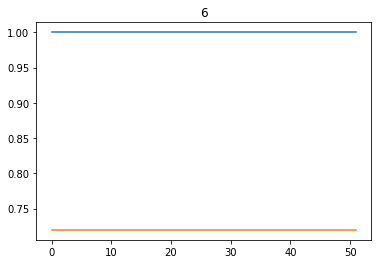

15 6 0.4444444444444444 0.8803995171105972


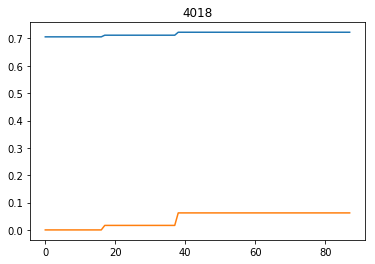

32 4018 0.5263157894736842 0.88377348429456


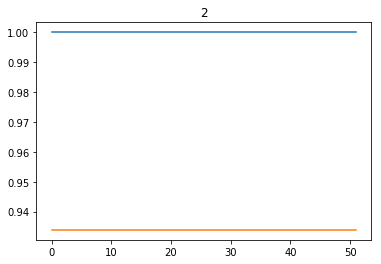

48 2 0.5862068965517241 0.8593241713285369


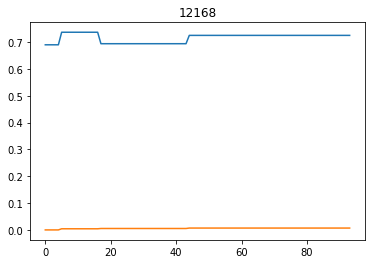

60 12168 0.5897435897435898 0.8572168963519484


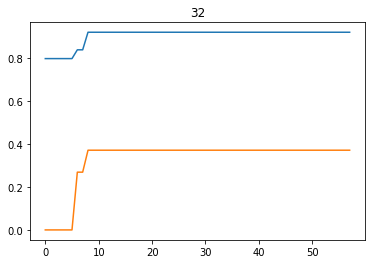

80 32 0.5510204081632653 0.8700806793630969


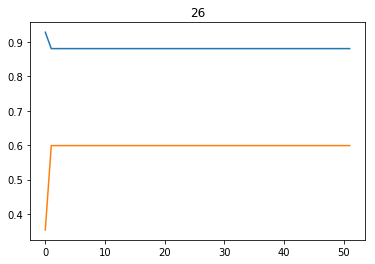

94 26 0.5423728813559322 0.875329369898594


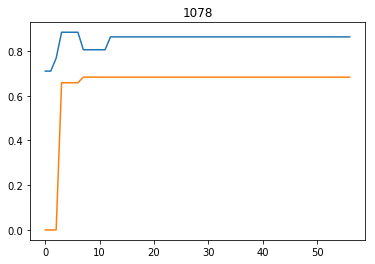

111 1078 0.5507246376811594 0.864008409212121


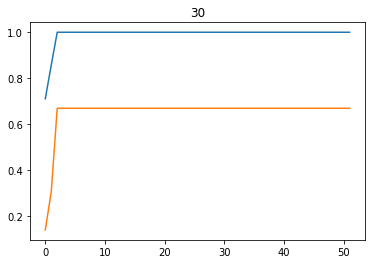

127 30 0.5443037974683544 0.8773355824834934


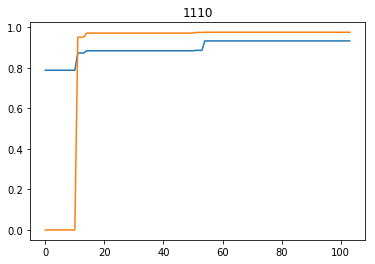

140 1110 0.5280898876404494 0.8772124065010019


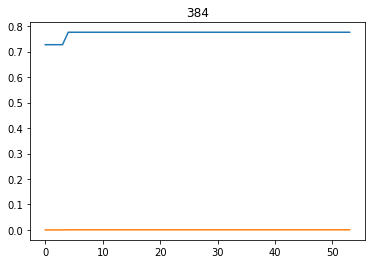

161 384 0.5555555555555556 0.870389550635707


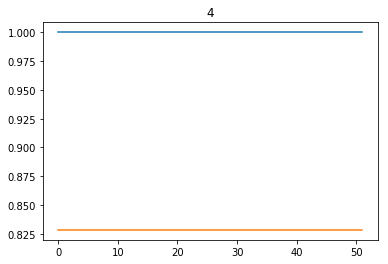

177 4 0.5321100917431193 0.8742448505267184


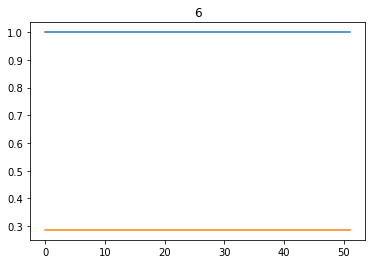

199 6 0.5294117647058824 0.8732796180402933


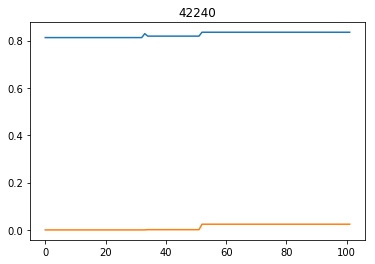

220 42240 0.5116279069767442 0.8763979266088682


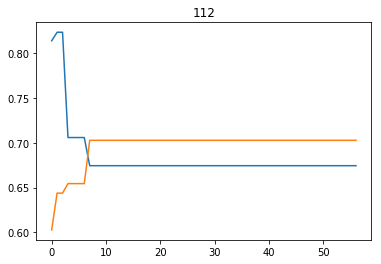

235 112 0.5035971223021583 0.8759358663556164


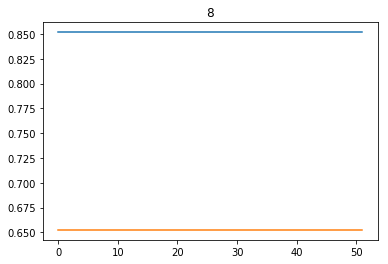

260 8 0.4966442953020134 0.878177540116204


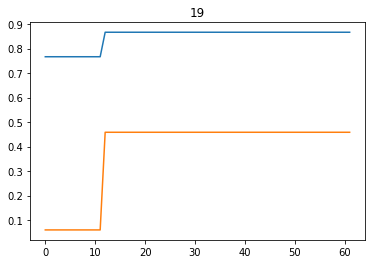

273 19 0.4779874213836478 0.8789792439406333


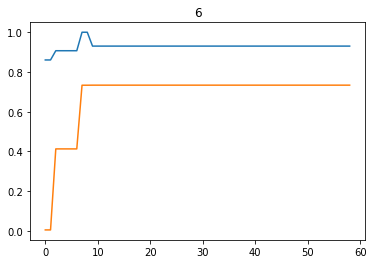

289 6 0.46153846153846156 0.8802249819232094


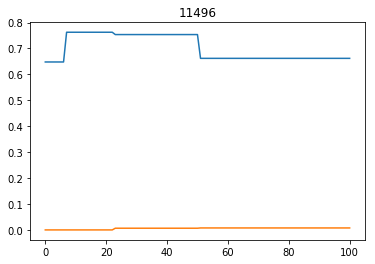

303 11496 0.48044692737430167 0.8759026037524216


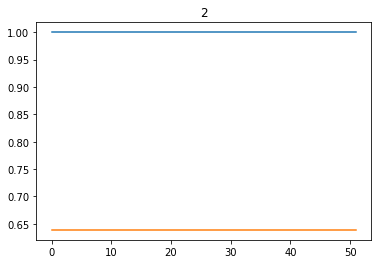

318 2 0.48148148148148145 0.8735562186187681


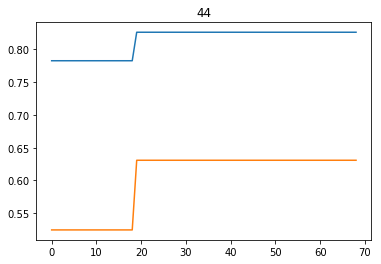

335 44 0.47738693467336685 0.8764297876726781


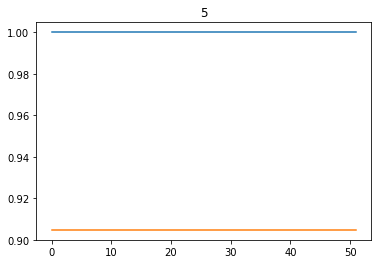

353 5 0.47368421052631576 0.873450597920537


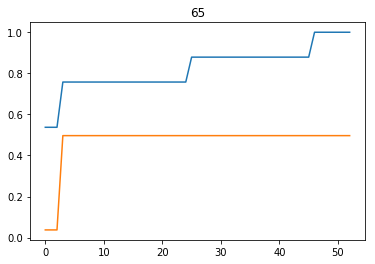

368 65 0.4703196347031963 0.8742504408596535


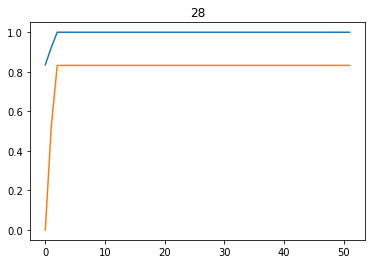

384 28 0.47161572052401746 0.8755774208384575


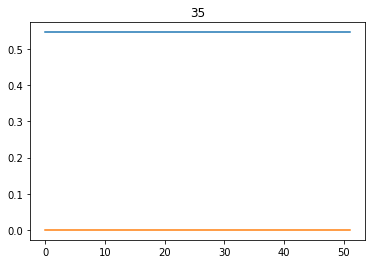

408 35 0.47280334728033474 0.8734566766584012


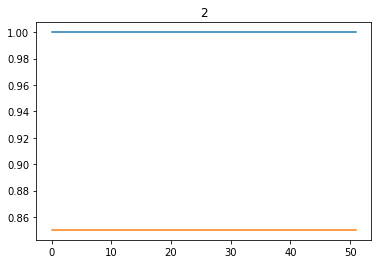

424 2 0.4738955823293173 0.8717796986093684


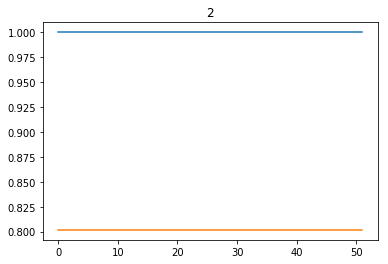

452 2 0.4749034749034749 0.8727246857403625


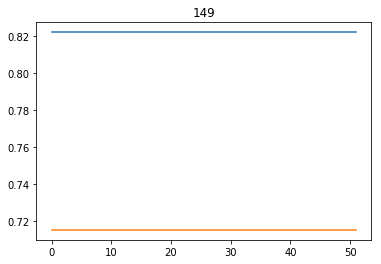

472 149 0.4758364312267658 0.8728473660654777


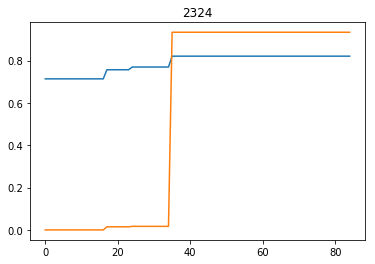

509 2324 0.4838709677419355 0.8725245015065423


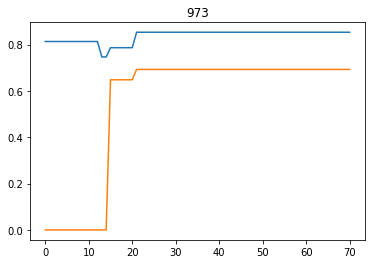

531 973 0.4844290657439446 0.8748097653800522


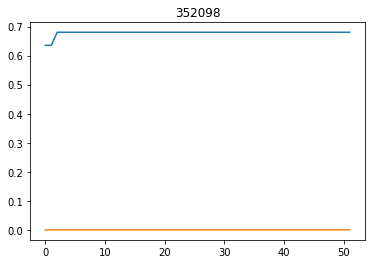

547 352098 0.47157190635451507 0.8751874555895507


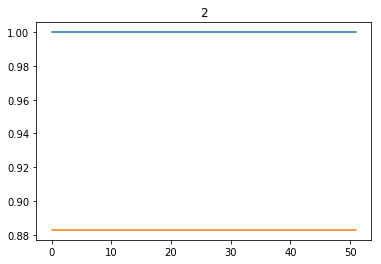

566 2 0.46601941747572817 0.8734515706975448


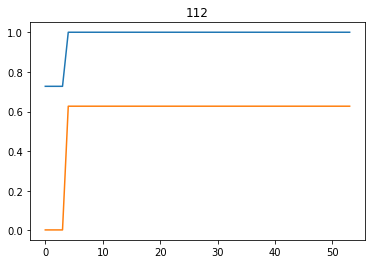

584 112 0.4670846394984326 0.8733616279338138


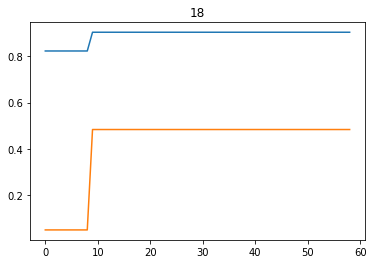

601 18 0.46504559270516715 0.8723966254700838


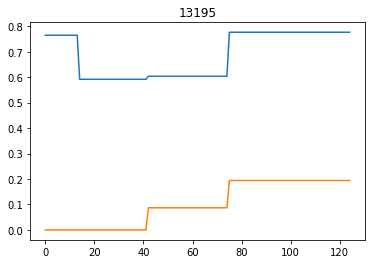

617 13195 0.4631268436578171 0.8730200096539336


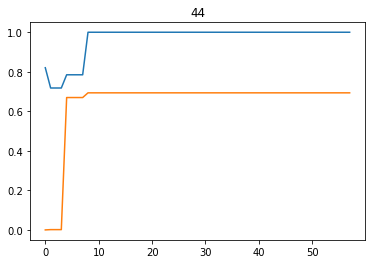

636 44 0.4670487106017192 0.8725113710294476


In [ ]:
data_folder = "../Składnica-frazowa-171220/**/*.xml"

res = []
f1 = []
iterator = []
forest_sizes = []

j=1

for i, filename in enumerate(list(glob.iglob(data_folder, recursive=True))[-1000:]):
      
    
    forest = ET.parse(filename)
    try:
        
        num_trees = number_of_trees_in_forest(forest)
        _ , stats = disambiguate(forest, rnn)
        res.append(stats[0][-1]>stats[0][0])
        f1.append(stats[0][-1])
        iterator.append(i)
        forest_sizes.append(num_trees)

        j = j+1
        
        plt.plot(stats[0])
        plt.plot(stats[1])
        plt.title(str(num_trees))        
        plt.savefig("Plots_disamb/"+str(i)+"_"+str(num_trees)+".png")
        plt.close()
        
        if j%10==0:
            plt.plot(stats[0])
            plt.plot(stats[1])
            plt.title(str(num_trees))
            plt.show()
            print(i, num_trees, np.mean(res),np.mean(f1))
    except:
        pass
    
pickle.dump(list(zip(iterator,forest_sizes,f1)), open("results_f1.pkl","wb"))
len(res)

In [ ]:
Wynik: srednio między 87 a 87.5 F1
    
Poprawic: liczenie f1 tylko na wierzchołkach dysjunktywnych - bez jednoznacznych liści
    
i też analiza jakości pstwa zrobić patrzac na takie własnie f1 a nie tak jak teraz

In [ ]:
data_folder = "../Składnica-frazowa-171220/**/*.xml"

j = 1

for filename in list(glob.iglob(data_folder, recursive=True))[-1000:]:
    
    print(j)
    j = j + 1
    
    forest = ET.parse(filename)
 
    try:
    
        num_trees = number_of_trees_in_forest(forest)
        print(num_trees)

        positive_tree = get_positive_tree(forest)
        
        
        
        
        directory = "Data/test"+str(j)
        os.makedirs(directory)
        for tree in trees:    
            write_dependency_format(transform_to_dependency_format(tree), directory)


            
            
        positive_tree = get_positive_tree(forest)
        f1=[]
        for tree in trees:
            f1.append(scores(positive_tree, tree)[2])

        #pickle.dump(f1, open(directory+"/f1.pkl","wb"))
        
        
        
        data0 = load_stanford_data4(directory+"/labels.txt", directory+"/parents.txt",directory+"/tokens.txt",directory+"/rules.txt",w2vecs["words2ids"],True,s['batch_size'],s['nc'])

        data_rules = load_stanford_data4(directory+"/labels.txt", directory+"/parents.txt",directory+"/rules.txt",directory+"/rules.txt",rnn.rules2ids,True,s['batch_size'],s['nc'])
        data_rules = [x[0] for x in data_rules]

        data = [data0[i]+[data_rules[i]] for i in range(len(data0))]

        probs = []
        for i in range(len(data)):
            probs.append(rnn.predict_proba(data[i][0],data[i][4],data[i][1], data[i][3])[-1][1])
        
        plt.scatter(f1,probs)
        plt.title(str(len(trees)))
        plt.savefig("Plots/"+str(j)+"_"+str(num_trees)+".png")
        plt.close()
        
    except:
        pass
    
    
        
print("Liczba drzew: ",len(trees))

NameError: name '_check_sentence' is not defined